In [186]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Plan

## 1.    Mettre les données dans un format propice au ML
    - Train/test
    - Encodage
    - Nettoyage des NaN

## 2.    Améliorer la performance du modèle
    - Feature Selection
    - Feature Ingeneering
    - Feature Scaling
    - Suppression des Outliers

In [187]:
# On set les options de print et on récupère les données
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
dataset = pd.read_excel('dataset.xlsx')
df = dataset.copy()
y = dataset['SARS-Cov-2 exam result']

# On sélectionne les variables déclarées comme utile lors de la première étape

Création des sous-ensembles et restriction du dataframe à ces ensembles

In [188]:
missing_rate = dataset.isna().sum()/dataset.shape[0]
key_col = ['Patient age quantile','SARS-Cov-2 exam result']
y = dataset[key_col[1]]

# Atteints ou non du COVID 19
positive_dataset = df[y=='positive']
negative_dataset = df[y=='negative']

# Celles à 76% de NaN (virus) et à 89% de NaN (blood)
blood_col = df.columns[(missing_rate<0.9) & (missing_rate>0.8) ]
blood_col = list(set(blood_col).intersection(set(df.select_dtypes('float').columns)))
virus_col = df.columns[(missing_rate<0.8) & (missing_rate>0.7)]

df = df[blood_col+list(virus_col)+key_col]
print(df.columns)
print(df.head())

Index(['Lymphocytes', 'Mean platelet volume ', 'Mean corpuscular volume (MCV)',
       'Leukocytes', 'Platelets', 'Hemoglobin',
       'Mean corpuscular hemoglobin concentration (MCHC)', 'Red blood Cells',
       'Mean corpuscular hemoglobin (MCH)', 'Eosinophils', 'Monocytes',
       'Hematocrit', 'Basophils', 'Red blood cell distribution width (RDW)',
       'Respiratory Syncytial Virus', 'Influenza A', 'Influenza B',
       'Parainfluenza 1', 'CoronavirusNL63', 'Rhinovirus/Enterovirus',
       'Coronavirus HKU1', 'Parainfluenza 3', 'Chlamydophila pneumoniae',
       'Adenovirus', 'Parainfluenza 4', 'Coronavirus229E', 'CoronavirusOC43',
       'Inf A H1N1 2009', 'Bordetella pertussis', 'Metapneumovirus',
       'Parainfluenza 2', 'Patient age quantile', 'SARS-Cov-2 exam result'],
      dtype='object')
   Lymphocytes  Mean platelet volume   Mean corpuscular volume (MCV)  \
0          NaN                    NaN                            NaN   
1     0.318366               0.010677     

Création du train_set et du test_set

In [189]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer

train_set,test_set = train_test_split(df,test_size=0.2,random_state=0)
print(train_set.columns)



Index(['Lymphocytes', 'Mean platelet volume ', 'Mean corpuscular volume (MCV)',
       'Leukocytes', 'Platelets', 'Hemoglobin',
       'Mean corpuscular hemoglobin concentration (MCHC)', 'Red blood Cells',
       'Mean corpuscular hemoglobin (MCH)', 'Eosinophils', 'Monocytes',
       'Hematocrit', 'Basophils', 'Red blood cell distribution width (RDW)',
       'Respiratory Syncytial Virus', 'Influenza A', 'Influenza B',
       'Parainfluenza 1', 'CoronavirusNL63', 'Rhinovirus/Enterovirus',
       'Coronavirus HKU1', 'Parainfluenza 3', 'Chlamydophila pneumoniae',
       'Adenovirus', 'Parainfluenza 4', 'Coronavirus229E', 'CoronavirusOC43',
       'Inf A H1N1 2009', 'Bordetella pertussis', 'Metapneumovirus',
       'Parainfluenza 2', 'Patient age quantile', 'SARS-Cov-2 exam result'],
      dtype='object')


# On fait le preprocessing

In [190]:
# tranforme les str en 0 et 1
def encodage(df):
    code = {'positive':1,
            'negative':0,
            'detected':1,
            'not_detected':0}
    for col in df.select_dtypes('object'):
        df[col]=df[col].map(code)
    return df

In [191]:
def imputation(df):
    df = df.dropna(axis=0)
    return df


In [192]:
def feature_engeneering(df):
    df['est malade'] = df[virus_col].sum(axis=1) >= 1
    df = df.drop(virus_col, axis=1)
    return df

In [193]:
def preprocessing(df):
    df = encodage(df)
    df = feature_engeneering(df)
    df = imputation(df)
    y = df['SARS-Cov-2 exam result']
    X = df.drop('SARS-Cov-2 exam result',axis = 1)
    print(y.value_counts())
    return X,y

In [194]:
X_train,y_train = preprocessing(train_set)
X_test,y_test = preprocessing(test_set)


SARS-Cov-2 exam result
0    422
1     65
Name: count, dtype: int64
SARS-Cov-2 exam result
0    95
1    16
Name: count, dtype: int64


# Modélisation et Evaluation

In [195]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,  confusion_matrix, classification_report
from sklearn.model_selection import learning_curve
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA

Model

In [196]:
model1 = DecisionTreeClassifier(random_state=0)
# Pipeline:
    # 1 - On élève au carré les variables ayant de l'importance (+ on multiplie toutes les variables entre elles)
    # 2 - Sélectionne les k variables ayant le plus haut score de anova (f_classif)
    # 3 - RandomForestClassifier
model2 = make_pipeline(PolynomialFeatures(2),
                       SelectKBest(f_classif,k=10),
                       RandomForestClassifier(random_state=0))

Evaluation

In [197]:
def evaluation(model):
    print('Evaluation du model ',model)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    print(confusion_matrix(y_test,y_pred))
    print(classification_report(y_test,y_pred))
    N, train_score, val_score = learning_curve(model,X_train,y_train,cv = 4, scoring= 'f1', train_sizes=np.linspace(0.1,1,10))
    plt.figure()
    plt.title(model)
    plt.plot(N,train_score.mean(axis=1),label = 'train score')
    plt.plot(N,val_score.mean(axis=1),label = 'val score')

Evaluation du model  DecisionTreeClassifier(random_state=0)
[[88  7]
 [ 9  7]]
              precision    recall  f1-score   support

           0       0.91      0.93      0.92        95
           1       0.50      0.44      0.47        16

    accuracy                           0.86       111
   macro avg       0.70      0.68      0.69       111
weighted avg       0.85      0.86      0.85       111


Evaluation du model  Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('selectkbest', SelectKBest()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=0))])


c:\dev\machineLearning\.venv\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\dev\machineLearning\.venv\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[[91  4]
 [11  5]]
              precision    recall  f1-score   support

           0       0.89      0.96      0.92        95
           1       0.56      0.31      0.40        16

    accuracy                           0.86       111
   macro avg       0.72      0.64      0.66       111
weighted avg       0.84      0.86      0.85       111



c:\dev\machineLearning\.venv\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\dev\machineLearning\.venv\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\dev\machineLearning\.venv\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\dev\machineLearning\.venv\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\dev\machineLearning\.venv\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_i

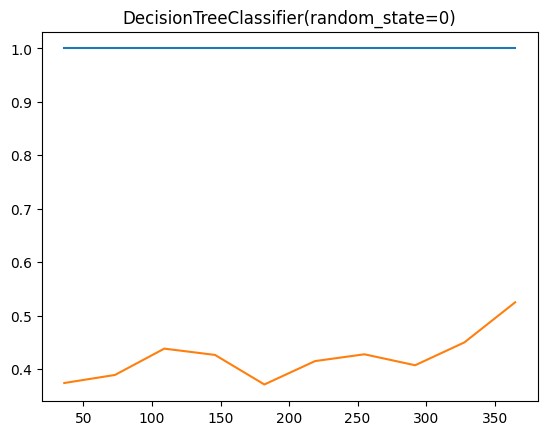

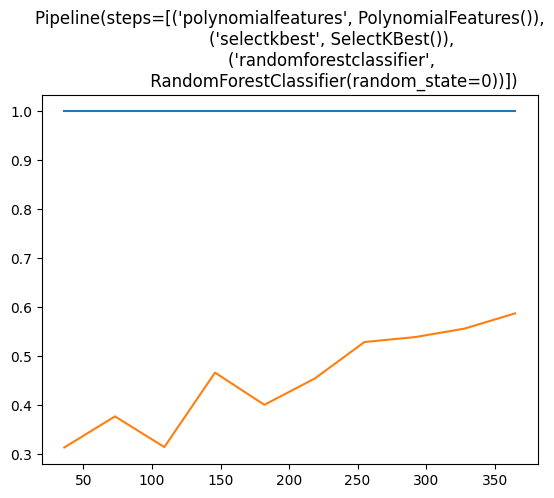

In [198]:
evaluation(model1)
print()
evaluation(model2)

Obtenir l'importance de nos variables pour établir notre model

AttributeError: 'Pipeline' object has no attribute 'feature_importances_'

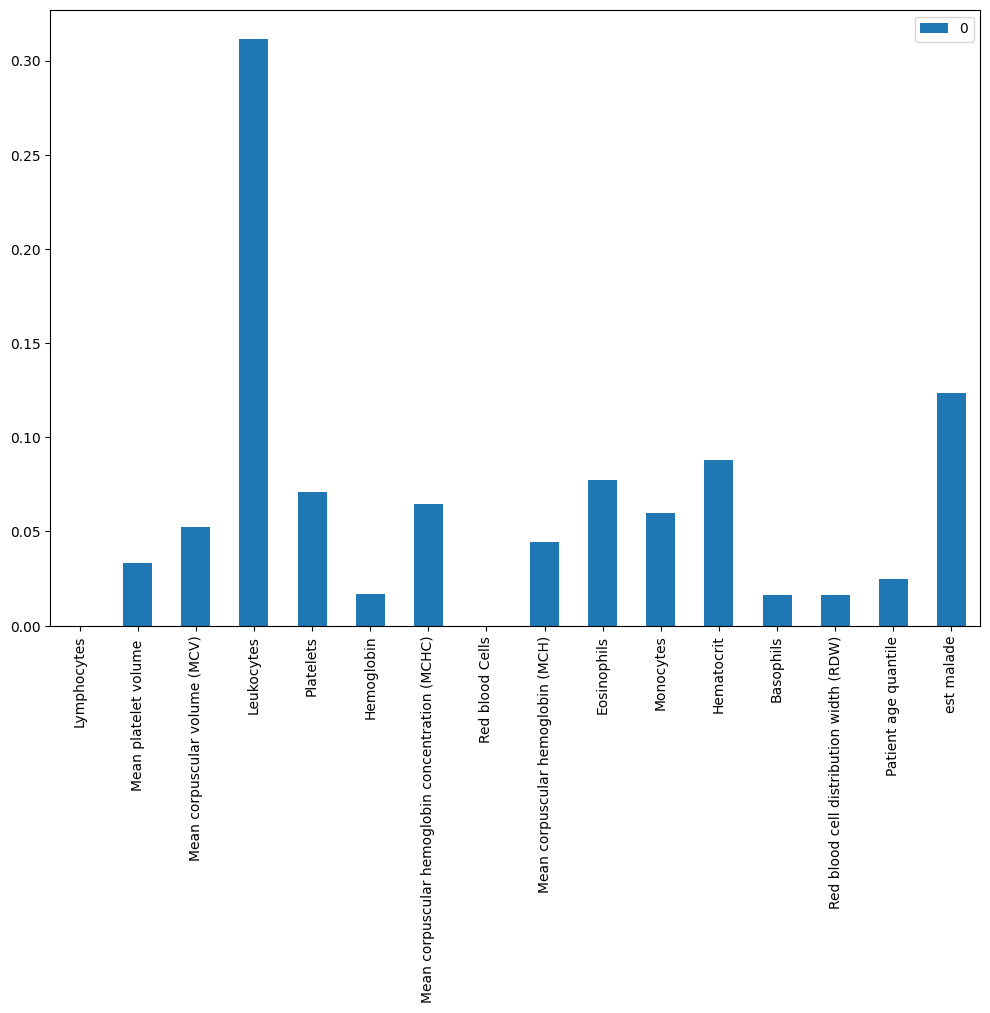

In [ ]:
pd.DataFrame(model1.feature_importances_, index=X_train.columns).plot.bar(figsize=(12, 8))
